# MadMiner tutorial

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the ML methods introduced in the following papers:
- J. Brehmer, K. Cranmer, G. Louppe, and J. Pavez: ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
- J. Brehmer, K. Cranmer, G. Louppe, and J. Pavez: ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020)
- J. Brehmer, G. Louppe, J. Pavez, and K. Cranmer: ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244)
- M. Stoye, J. Brehmer, G. Louppe, J. Pavez, and K. Cranmer: ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973)

## 0. Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner and [DelphesMiner](https://github.com/johannbrehmer/delphesminer) have to be in your PYTHONPATH.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.tools.plots import plot_2d_morphing_basis
from delphesprocessor.delphesprocessor import DelphesProcessor
from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from forge.forge import Forge

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [26]:
miner = GoldMine()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

10:29  
10:29  ------------------------------------------------------------
10:29  |                                                          |
10:29  |  MadMiner                                                |
10:29  |                                                          |
10:29  |  Version from July 31, 2018                              |
10:29  |                                                          |
10:29  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:29  |                                                          |
10:29  ------------------------------------------------------------
10:29  
10:29  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-50.0, 50.0))
10:29  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-50.0, 50.0))


## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [27]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)
miner.add_benchmark(
    {'CWL2':50., 'CPWL2':0.},
    'w2'
)

10:29  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
10:29  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
10:29  Added benchmark w2: CWL2 = 50.00, CPWL2 = 0.00e+00)


### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [28]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

10:29  Optimizing basis for morphing
10:29  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
10:29  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
10:29  Added benchmark w2: CWL2 = 50.00, CPWL2 = 0.00e+00)
10:29  Added benchmark morphing_basis_vector_3: CWL2 = -3.10e+00, CPWL2 = 25.00)
10:29  Added benchmark morphing_basis_vector_4: CWL2 = 0.41, CPWL2 = -4.71e+01)
10:29  Added benchmark morphing_basis_vector_5: CWL2 = 47.59, CPWL2 = 41.79)


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

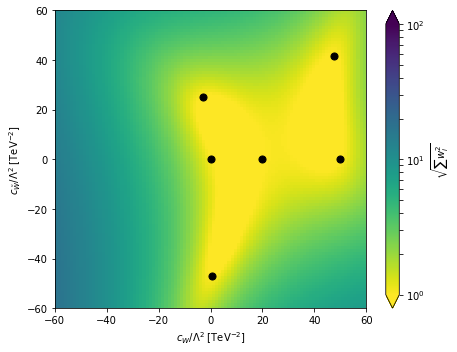

In [29]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

## 3. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [30]:
miner.save('data/madminer_example.h5')

10:30  Saving setup (including morphing) to data/madminer_example.h5


In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first. Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [31]:
miner.run(
    mg_directory=mg_dir,
    proc_card_file='cards/proc_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

10:30  Generating MadGraph process folder from cards/proc_card.dat at ./MG_process
10:30  Creating param and reweight cards in ./MG_process
10:30  Starting MadGraph and Pythia in ./MG_process


## 4. Run detector simulation and extract observables

The detector simulation and calculation of observables is not part of MadMiner. The reason is that different users might have very different requirements here: while a phenomenologist might be content with the fast detector simulation from Delphes, an experimental analysis might require the full simulation through Geant4.

We provide the DelphesMiner package, which wraps around Delphes and allows for the fast extraction of observables into the HDF5 file.

Any user is free to replace the DelphesMiner step with a tool of their choice. 

In [32]:
dm = DelphesProcessor(debug=False)

10:43  
10:43  ------------------------------------------------------------
10:43  |                                                          |
10:43  |  DelphesProcessor                                        |
10:43  |                                                          |
10:43  |  Version from July 31, 2018                              |
10:43  |                                                          |
10:43  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:43  |                                                          |
10:43  ------------------------------------------------------------
10:43  
10:43  Hi! How are you today?


After creating the DelphesProcessor object, one can add a number of HepMC event samples and have it run Delphes:

In [33]:
dm.add_hepmc_sample('MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz', sampled_from_benchmark='sm')

dm.run_delphes(delphes_directory=mg_dir + '/Delphes',
               delphes_card='cards/delphes_card.dat',
               initial_command='source activate python2')

10:43  Adding HepMC sample at MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz
10:43  Running Delphes at /Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes


The next step is the definition of observables through a name and a python expression. For the latter, you can use the objects `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

There is an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with `np.nan`. NaNs in training or test data for machine learning will cause some problems, so we stick to `required=True`.

In [34]:
dm.add_observable('pt_j1', 'j[0].pt', required=True)
#dm.add_observable('pt_j2', 'j[1].pt', required=True)
dm.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())', required=True)
#dm.add_observable('delta_eta_jj', 'abs(j[0].eta - j[1].eta)', required=True)
#dm.add_observable('m_jj', '(j[0] + j[1]).m', required=True)

10:46  Adding required observable pt_j1 = j[0].pt
10:46  Adding required observable delta_phi_jj = abs(j[0].phi() - j[1].phi())


The function `analyse_delphes_samples` extracts all these observables from the Delphes ROOT file(s) generated before:

In [35]:
dm.analyse_delphes_samples()

10:46  Analysing Delphes sample MG_process/Events/run_01/tag_1_pythia8_events_delphes.root
10:46  Requiring existence of observable pt_j1: 49857 events pass, 143 events removed
10:46  Requiring existence of observable delta_phi_jj: 46487 events pass, 3513 events removed


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [36]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

10:46  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_data.h5


It's easy to check some (normalized) distributions at this stage

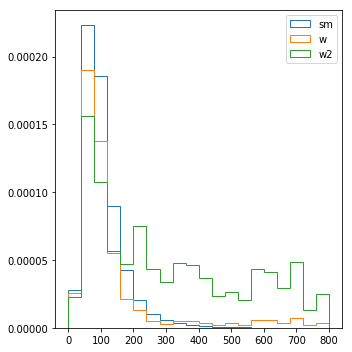

In [37]:
fig = plt.figure(figsize=(5,5))

for label in ['sm', 'w', 'w2']:
    plt.hist(dm.observations['pt_j1'], range=(0.,800.), bins=20, histtype='step', weights=dm.weights[label], label=label)
    
plt.legend()
plt.tight_layout()
plt.show()

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In [38]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

10:46  
10:46  ------------------------------------------------------------
10:46  |                                                          |
10:46  |  MadMiner                                                |
10:46  |                                                          |
10:46  |  Version from July 31, 2018                              |
10:46  |                                                          |
10:46  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:46  |                                                          |
10:46  ------------------------------------------------------------
10:46  
10:46  Copying setup from data/madminer_example_with_data.h5 to data/madminer_example_shuffled.h5
10:46  Loading samples from file 1 / 1 at data/madminer_example_with_data.h5


## 6. Refine data: Make (unweighted) training and test samples

The next step is handled by the MadMiner class `Refinery`. From all the data we have in the HDF5 file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the Machine Learning algorithms.

In [11]:
refinery = Refinery('data/madminer_example_shuffled.h5', debug=False)

11:57  
11:57  ------------------------------------------------------------
11:57  |                                                          |
11:57  |  MadMiner                                                |
11:57  |                                                          |
11:57  |  Version from July 31, 2018                              |
11:57  |                                                          |
11:57  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
11:57  |                                                          |
11:57  ------------------------------------------------------------
11:57  
11:57  Loading data from data/madminer_example_shuffled.h5
11:57  Found 2 parameters:
11:57     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-50.0, 50.0))
11:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-50.0, 50.0))
11:57  Found 6 benchmarks:
11:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00


The `Refinery` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `smithy` module.

In [13]:
x, theta, t_xz = refinery.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train0'
)

11:58  Extracting training sample for local score regression. Sampling and score evaluation according to ('benchmark', 'sm')


In [83]:
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=random_morphing_thetas(1000, [('gaussian', 0., 30.), ('gaussian', 0., 30.)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train1'
)

18:22  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (1000, [('gaussian', 0.0, 30.0), ('gaussian', 0.0, 30.0)])), denominator hypothesis: ('benchmark', 'sm')
18:23  1 negative weights (3.073046310807904e-05)


In [11]:
x, theta0, theta1, y, r_xz, t_xz0, t_xz1 = refinery.extract_samples_train_more_ratios(
    theta0=random_morphing_thetas(1000, [('gaussian', 0., 30.), ('gaussian', 0., 30.)]),
    theta1=random_morphing_thetas(1000, [('gaussian', 0., 30.), ('gaussian', 0., 30.)]),
    #additional_thetas=[random_morphing_thetas(1000, [('gaussian', 0., 30.), ('gaussian', 0., 30.)]) for _ in range(9)],
    n_samples=100000,
    folder='./data/samples',
    filename='train2'
)

09:23  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (1000, [('gaussian', 0.0, 30.0), ('gaussian', 0.0, 30.0)])), denominator hypothesis: ('random', (1000, [('gaussian', 0.0, 30.0), ('gaussian', 0.0, 30.0)]))
09:23  1 negative weights (3.073046310807904e-05)


In [42]:
x, theta = refinery.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=20000,
    folder='./data/samples',
    filename='test'
)

x_bsm, theta_bsm = refinery.extract_samples_test(
    theta=constant_benchmark_theta('w2'),
    n_samples=20000,
    folder='./data/samples',
    filename='test_bsm'
)

10:46  Extracting evaluation sample. Sampling according to ('benchmark', 'sm')
10:46  Extracting evaluation sample. Sampling according to ('benchmark', 'w2')


Let's have a look at some distributions and correlations in this test sample:

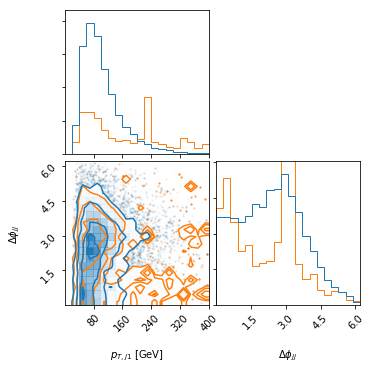

In [46]:
import corner

#labels = [r'$p_{T,j1}$ [GeV]', r'$p_{T,j2}$ [GeV]', r'$\Delta \phi_{jj}$', r'$\Delta \eta_{jj}$', r'$m_{jj}$']
#ranges = [(0., 300.), (0., 200.), (0.,6.2), (0.,8.), (0.,1500.)]
labels = [r'$p_{T,j1}$ [GeV]', r'$\Delta \phi_{jj}$']
ranges = [(0., 400.), (0.,6.2)]

fig = corner.corner(x_bsm, color='C1', labels=labels, range=ranges)
_ = corner.corner(x, color='C0', labels=labels, range=ranges, fig=fig)

We can also calculate total cross sections:

In [47]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = refinery.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'w2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = refinery.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('gaussian', 0., 30.), ('gaussian', 0., 30.)])
)

10:51  theta [0. 0.]: xsec = (0.0006142383790574968 +/- 2.8492332828216978e-06) pb
10:51  theta [20.  0.]: xsec = (0.0005198451690375805 +/- 1.1396481364020613e-05) pb
10:51  theta [50.  0.]: xsec = (0.0010751893278211355 +/- 7.639644999251403e-05) pb
10:51  theta [-3.10094136 25.00113204]: xsec = (0.0009651892469264567 +/- 2.1010664364318778e-05) pb
10:51  theta [  0.40716244 -47.11518255]: xsec = (0.0016597274225205183 +/- 6.254759526734882e-05) pb
10:51  theta [47.59036343 41.79090077]: xsec = (0.0017711425898596644 +/- 9.275374263960356e-05) pb
10:51  theta [-21.12195021 -14.63357399]: xsec = (0.001207519312902877 +/- 5.2773465080788325e-05) pb
10:51  theta [ 18.41321118 -24.32009861]: xsec = (0.0008067881045954726 +/- 3.6449677118196754e-05) pb
10:51  theta [-23.58127734  24.86136703]: xsec = (0.0015192892464469955 +/- 7.866750113094482e-05) pb
10:51  theta [-31.57970265  14.96129302]: xsec = (0.001643832183205847 +/- 0.00010741986003844943) pb
10:51  theta [56.5900686   5.1913881

10:51  theta [15.26286337 40.39419609]: xsec = (0.0012699422264285016 +/- 5.5026224592267755e-05) pb
10:51  theta [ 2.64596766 -3.98202605]: xsec = (0.0005878134383863238 +/- 4.626826293210617e-06) pb
10:51  theta [-34.75998271 -31.70970632]: xsec = (0.002101355239983438 +/- 0.00011113053142929974) pb
10:51  theta [-68.127671  -25.5071991]: xsec = (0.003975216607721897 +/- 0.0003191744440605155) pb
10:51  theta [40.28860564 37.34539041]: xsec = (0.0014231363881592723 +/- 7.189566972130007e-05) pb
10:51  theta [-15.71022324 -26.00932412]: xsec = (0.0012544400863781341 +/- 4.359217477253098e-05) pb
10:51  theta [61.95631352 21.95832256]: xsec = (0.0017174425633401137 +/- 0.00011129955851376821) pb
10:51  theta [ -3.10833077 -43.33828547]: xsec = (0.001546290013784399 +/- 5.4435372710122086e-05) pb
10:51  theta [  6.7840025  -31.29552447]: xsec = (0.0010096660981274827 +/- 3.56710224614364e-05) pb
10:51  theta [-22.31141995  21.15262567]: xsec = (0.0013890358463778244 +/- 6.96756129585339

10:51  theta [25.62309758 -1.83273845]: xsec = (0.000563150871825594 +/- 1.5083070276266983e-05) pb
10:51  theta [45.38962139 19.25803648]: xsec = (0.0010858487505399413 +/- 5.1060437234120446e-05) pb
10:51  theta [-23.49645974  35.22467256]: xsec = (0.001821683630152436 +/- 9.0836556500965e-05) pb
10:51  theta [-59.21143145  37.12685676]: xsec = (0.003804926180889542 +/- 0.00033205558669899217) pb
10:51  theta [ 29.2336497  -28.61183124]: xsec = (0.0010149321544875478 +/- 6.528443201052147e-05) pb
10:51  theta [42.76082762 24.17397016]: xsec = (0.001112023800371627 +/- 5.091509445396213e-05) pb
10:51  theta [25.69710835 51.51478729]: xsec = (0.0017870050374353143 +/- 8.83305042198781e-05) pb
10:51  theta [-11.19501716  -2.33955333]: xsec = (0.0008307983189292238 +/- 2.2719953865378025e-05) pb
10:51  theta [-23.15260421 -16.60044019]: xsec = (0.00130428586197842 +/- 6.0010797288769954e-05) pb
10:51  theta [-33.8221594  -62.23629049]: xsec = (0.0033865725228142225 +/- 0.0001496493320149

10:51  theta [-10.75951957 -16.84212988]: xsec = (0.0009457923836834769 +/- 2.6396419171376255e-05) pb
10:51  theta [31.80080359 -5.7179599 ]: xsec = (0.0006592839791552179 +/- 2.8925357495118457e-05) pb
10:51  theta [ 5.90923104 12.02980191]: xsec = (0.0006156913399179041 +/- 1.3288629498056497e-05) pb
10:51  theta [-11.81894363 -43.87219669]: xsec = (0.0017383522408931985 +/- 6.126039952294223e-05) pb
10:51  theta [  0.42735383 -27.03456316]: xsec = (0.0009531596984321055 +/- 2.6894131899005963e-05) pb
10:51  theta [ 28.27839053 -37.63832875]: xsec = (0.0012936575196614434 +/- 8.332867499576009e-05) pb
10:51  theta [-22.99333394  25.46512755]: xsec = (0.0015128370637743794 +/- 7.671469597874107e-05) pb
10:51  theta [-37.62720065 -39.59173389]: xsec = (0.0024918009133937736 +/- 0.0001295167834794547) pb
10:51  theta [ 9.73349548 -3.79989304]: xsec = (0.0005294771980504955 +/- 8.800716405015682e-06) pb
10:51  theta [ 11.02775918 -19.35288288]: xsec = (0.0006990034750820783 +/- 2.166468

10:51  theta [  5.97024053 -12.47320589]: xsec = (0.0006220637321092879 +/- 1.1581813496128309e-05) pb
10:51  theta [-21.43633637  42.18161017]: xsec = (0.0020094043689846356 +/- 9.244018178917253e-05) pb
10:51  theta [ -8.23074469 -25.6900849 ]: xsec = (0.001065043373150461 +/- 3.011452074761124e-05) pb
10:51  theta [-21.72107182 -21.97705212]: xsec = (0.0013493874847521855 +/- 5.719595520102134e-05) pb
10:51  theta [36.94072807 44.67131725]: xsec = (0.0016319889056222697 +/- 8.475499964130019e-05) pb
10:51  theta [ 57.54485636 -70.9160403 ]: xsec = (0.0038636477847731774 +/- 0.0003303029541558783) pb
10:51  theta [ -8.04134944 -73.92732631]: xsec = (0.003329100884497891 +/- 0.00013505980337811128) pb
10:51  theta [-10.19932275   5.47309401]: xsec = (0.0008222306228769715 +/- 2.077474669013725e-05) pb
10:51  theta [ 17.8013728  -11.44965047]: xsec = (0.0005796430070882362 +/- 1.7762234884793602e-05) pb
10:51  theta [ -3.14912635 -15.43432034]: xsec = (0.0007728430168109902 +/- 1.48044

10:51  theta [-46.89360227 -40.90380447]: xsec = (0.0030216848140601793 +/- 0.0001764642247202519) pb
10:51  theta [29.55831472 10.341192  ]: xsec = (0.0006482110644369255 +/- 1.9176615853692245e-05) pb
10:51  theta [-44.20426855  51.84843457]: xsec = (0.003501707360225529 +/- 0.00024510552343969027) pb
10:51  theta [-21.68046828 -51.64221086]: xsec = (0.0023626430652161365 +/- 9.317312806389962e-05) pb
10:51  theta [-33.41636464 -10.90800482]: xsec = (0.0016447022343415553 +/- 0.0001018298849297687) pb
10:51  theta [-23.19136167  64.57603359]: xsec = (0.0032300978010517552 +/- 0.0001490317587657352) pb
10:51  theta [-3.98967613 46.40106321]: xsec = (0.0017137984896771548 +/- 5.415066491461254e-05) pb
10:51  theta [-8.36023585 -0.46499674]: xsec = (0.000763776126824316 +/- 1.5954291499035135e-05) pb
10:51  theta [ -6.46535336 -29.13905026]: xsec = (0.0011185616653298486 +/- 3.250586664710567e-05) pb
10:51  theta [59.23829881 19.92872672]: xsec = (0.0015676309977283658 +/- 9.91782241953

10:51  theta [ 0.26876038 34.02761157]: xsec = (0.0011653681304969112 +/- 3.229932949089121e-05) pb
10:51  theta [31.02866677 54.90267624]: xsec = (0.0020124268535945304 +/- 0.00010282781740597091) pb
10:51  theta [ 20.29420514 -26.14195838]: xsec = (0.0008604750103643169 +/- 4.23382325280257e-05) pb
10:51  theta [-21.95641338 -18.10420475]: xsec = (0.001286673589460665 +/- 5.640203165130788e-05) pb
10:51  theta [-2.12487105  0.94318573]: xsec = (0.0006467148526086555 +/- 4.4943420395792935e-06) pb
10:51  theta [44.18932224 -8.28840554]: xsec = (0.0009459118906661509 +/- 6.834413808203911e-05) pb
10:51  theta [20.13442588 56.51033557]: xsec = (0.002009952494352429 +/- 9.307132237559131e-05) pb
10:51  theta [50.7105748  85.69837341]: xsec = (0.004462247567035039 +/- 0.00023588519083200224) pb
10:51  theta [-24.53900412  28.72403493]: xsec = (0.0016569497601862618 +/- 8.722364153700882e-05) pb
10:51  theta [  0.56275479 -45.9769504 ]: xsec = (0.001607554804739429 +/- 6.0134891829790224e-

10:51  theta [-42.96730013  -9.0036652 ]: xsec = (0.0020989531146958676 +/- 0.00015252275891948993) pb
10:51  theta [-30.28172628  50.85289117]: xsec = (0.002751536303493573 +/- 0.00015264830415143632) pb
10:51  theta [ 15.30929231 -76.58098486]: xsec = (0.003328007329729277 +/- 0.00016567999752263127) pb
10:51  theta [-81.59423502  10.69632696]: xsec = (0.004934999853311329 +/- 0.000490188271744916) pb
10:51  theta [10.29225687 -5.00549528]: xsec = (0.0005322227708460904 +/- 9.289629386020937e-06) pb
10:51  theta [-26.45424159 -53.32629781]: xsec = (0.0026107304776308094 +/- 0.00010844678347196635) pb
10:51  theta [-16.48861961  20.78337762]: xsec = (0.0011908543905033537 +/- 4.702303827075869e-05) pb
10:51  theta [-21.71151465  -4.56574262]: xsec = (0.0011436107767032204 +/- 5.452876992665471e-05) pb
10:51  theta [ 4.76371079 59.01815705]: xsec = (0.0022135786504322978 +/- 8.229588891806176e-05) pb
10:51  theta [12.23051756 21.03670492]: xsec = (0.0007171596402505425 +/- 2.6089302597

10:51  theta [ 6.76276243 34.74799121]: xsec = (0.0011119008048947954 +/- 3.775575984004534e-05) pb
10:51  theta [-33.35516404   9.84100892]: xsec = (0.0016565204690922827 +/- 0.0001122214672467866) pb
10:51  theta [32.12831026 20.08924319]: xsec = (0.000817150773832908 +/- 3.273562096194655e-05) pb
10:51  theta [-2.17932069 14.78519555]: xsec = (0.0007538723970138218 +/- 1.1062638399793046e-05) pb
10:51  theta [ 11.96969653 -29.77615813]: xsec = (0.0009429135275146222 +/- 3.768293194275982e-05) pb
10:51  theta [-91.93459294  -6.23793574]: xsec = (0.00582848990353525 +/- 0.0005701016885066775) pb
10:51  theta [-21.63924917  10.698033  ]: xsec = (0.0011983265038280372 +/- 5.952315166517005e-05) pb
10:51  theta [-37.46801151  -4.93153604]: xsec = (0.0017964553146977919 +/- 0.00012414512338467356) pb
10:51  theta [-14.7780546 -54.014543 ]: xsec = (0.0022784453040420416 +/- 8.579648418314132e-05) pb
10:51  theta [ 63.35920166 -32.30868123]: xsec = (0.002150991970877968 +/- 0.00022491650642

10:51  theta [46.51461705  1.11424627]: xsec = (0.0009667729866651334 +/- 6.133431521336277e-05) pb
10:51  theta [21.13409306 17.09115855]: xsec = (0.0006549718423373464 +/- 2.5420851188201192e-05) pb
10:51  theta [-17.41904235   7.84842148]: xsec = (0.0010340215897232555 +/- 4.279517592667835e-05) pb
10:51  theta [ 35.15434939 -35.22039459]: xsec = (0.0013220889431373368 +/- 9.793654527033387e-05) pb
10:51  theta [ 33.73495733 -16.99517577]: xsec = (0.0008243157247827649 +/- 5.284727401952157e-05) pb
10:51  theta [-50.73246842  12.0955213 ]: xsec = (0.0026120296728667355 +/- 0.00022143597786970825) pb
10:51  theta [-56.77667786  30.5091843 ]: xsec = (0.0034106250173261505 +/- 0.0002976687805345452) pb
10:51  theta [6.39028667 3.63266278]: xsec = (0.0005496412112267592 +/- 8.44142318693646e-06) pb
10:51  theta [-37.31724233   9.36469577]: xsec = (0.0018384154343309997 +/- 0.00013316535490936741) pb
10:51  theta [14.21013927 35.45236707]: xsec = (0.0010949833423699513 +/- 4.607844161251

10:51  theta [ 8.94533129 60.3355492 ]: xsec = (0.0022481837856527763 +/- 8.887632470795456e-05) pb
10:51  theta [ -8.66500926 -46.50110904]: xsec = (0.0017806338638974985 +/- 6.32710995043096e-05) pb
10:51  theta [ 30.65331565 -45.90985583]: xsec = (0.0016643950558147868 +/- 0.00011146412876369541) pb
10:51  theta [-23.31930548  31.52427844]: xsec = (0.0016943476329749469 +/- 8.510408815776489e-05) pb
10:51  theta [-17.74347288   2.36760292]: xsec = (0.0010134661243890856 +/- 4.2175961998655345e-05) pb
10:51  theta [  4.29041196 -20.19310927]: xsec = (0.0007570371857606936 +/- 1.8866611029186357e-05) pb
10:51  theta [-13.69859971  34.79123222]: xsec = (0.0014891480829398419 +/- 5.27924703475115e-05) pb
10:51  theta [-57.54827695  23.20214794]: xsec = (0.003261844261492777 +/- 0.00029039325048619646) pb
10:51  theta [-23.46886807  38.20490048]: xsec = (0.0019274394743067354 +/- 9.507936455344567e-05) pb
10:51  theta [1.77672408 3.29433328]: xsec = (0.0005961887843682561 +/- 4.391131789

10:51  theta [16.39992654 46.35543604]: xsec = (0.0015128686487744947 +/- 6.700025167507094e-05) pb
10:51  theta [24.88942353  7.99806888]: xsec = (0.000578254498059988 +/- 1.556533196539131e-05) pb
10:51  theta [-11.72506999  -2.40745302]: xsec = (0.0008439488325907409 +/- 2.4056733071653427e-05) pb
10:51  theta [26.66089354 19.33046779]: xsec = (0.0007343276563275212 +/- 2.9518992905301253e-05) pb
10:51  theta [15.57868411 45.48656881]: xsec = (0.0014757754428556605 +/- 6.444017873312688e-05) pb
10:51  theta [-1.1220774  35.57454626]: xsec = (0.0012384300046787832 +/- 3.438648193270236e-05) pb
10:51  theta [17.76966122  8.37537325]: xsec = (0.000541522785162154 +/- 1.57813911434037e-05) pb
10:51  theta [ 66.24542937 -12.33406862]: xsec = (0.0018224477408559539 +/- 0.00018523634625979162) pb
10:51  theta [23.41700054 13.50419373]: xsec = (0.0006190397657519786 +/- 2.1284766643679066e-05) pb
10:51  theta [51.03941859  5.69756806]: xsec = (0.001116101961626725 +/- 7.304447881275098e-05)

10:51  theta [37.79031698 97.31876892]: xsec = (0.005147186038788421 +/- 0.0002541061757758508) pb
10:51  theta [-36.28072301  40.08203531]: xsec = (0.0025509422206753535 +/- 0.00016725171757909593) pb
10:51  theta [-40.49621287  -2.77005109]: xsec = (0.0019432886793202449 +/- 0.00014189084729999645) pb
10:51  theta [ 10.69534363 -22.83162514]: xsec = (0.0007707091352589358 +/- 2.5948373530403836e-05) pb
10:51  theta [ 11.58262608 -38.99018226]: xsec = (0.0012475671172970174 +/- 5.419187743247253e-05) pb
10:51  theta [-23.16648431  55.36245227]: xsec = (0.002695240492037963 +/- 0.00012612043091479486) pb
10:51  theta [-17.15709841 -12.05410389]: xsec = (0.0010523375993381277 +/- 4.0020822212912175e-05) pb
10:51  theta [  6.36268564 -33.72510244]: xsec = (0.0010879411101032501 +/- 3.944847182426848e-05) pb
10:51  theta [33.22888312 35.79385136]: xsec = (0.001236985621812623 +/- 6.17174384288294e-05) pb
10:51  theta [ 17.60076204 -25.8153168 ]: xsec = (0.0008402777535073248 +/- 3.7837285

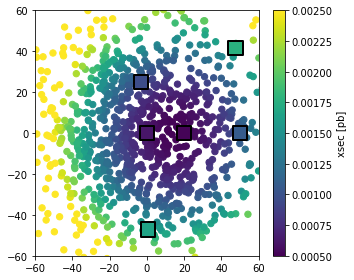

In [60]:
fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=0.0005, vmax=.0025,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=0.0005, vmax=.0025, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-60.,60.)
plt.ylim(-60.,60.)
plt.tight_layout()
plt.show()

For debugging, you can also access the full list of observables and benchmark weights (same units as in the LHE file) in the HDF5 file:

In [61]:
all_x, all_weights = refinery.extract_raw_data(theta=[0.0,0.1])

## 7. Forge estimators for likelihood ratio or score

It's now time to build the neural networks that estimate likelihood ratios or the score. The central object for this is the `Forge` class. It defines functions that train, save, load, and evaluate the estimators.

In [4]:
forge = Forge(debug=False)

11:37  
11:37  ------------------------------------------------------------
11:37  |                                                          |
11:37  |  Forge                                                   |
11:37  |                                                          |
11:37  |  Version from July 31, 2018                              |
11:37  |                                                          |
11:37  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
11:37  |                                                          |
11:37  ------------------------------------------------------------
11:37  


### 7a. Learning likelihood ratios

First, we will use the RASCAL method described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). Other implemented methods include CARL, CASCAL, and ROLR described in the same publications, as well as ALICE and ALICES which are introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

All of these methods exist both in a "single parameterized" version, in which only the dependence of the likelihood ratio on the numerator is modelled, and a "doubly parameterized" version, in which both the dependence on the numerator and denominator parameters is modelled. For the single parameterized version, use `method='rascal'`, `method='alice'`, and so on. For the double parameterized version, use `method='rascal2'`, `method='alice2'`, etc. Note that for the doubly parameterized estimators you have to provide `theta1_filename`, and in the case of RASCAL and ALICE also `t_xz1_filename`.

In [65]:
forge.train(
    method='rascal',
    theta0_filename='data/samples/theta0_train1.npy',
    x_filename='data/samples/x_train1.npy',
    y_filename='data/samples/y_train1.npy',
    r_xz_filename='data/samples/r_xz_train1.npy',
    t_xz0_filename='data/samples/t_xz_train1.npy',
    n_hidden=(20,20),
    alpha=100.,
    n_epochs=5,
    validation_split=None,
    batch_size=256
)

forge.save('models/rascal')

14:59  
14:59  ------------------------------------------------------------
14:59  |                                                          |
14:59  |  Forge                                                   |
14:59  |                                                          |
14:59  |  Version from July 31, 2018                              |
14:59  |                                                          |
14:59  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
14:59  |                                                          |
14:59  ------------------------------------------------------------
14:59  
14:59  Starting training
14:59    Method:                 rascal
14:59    Training data: theta0 at data/samples/theta0_train_rascal.npy
14:59                   x at data/samples/x_train_rascal.npy
14:59                   y at data/samples/y_train_rascal.npy
14:59                   r_xz at data/samples/r_xz_train_rascal.npy
14:59                   t_xz (theta0) at  data/

In [14]:
forge.train(
    method='rascal2',
    theta0_filename='data/samples/theta0_train2.npy',
    theta1_filename='data/samples/theta1_train2.npy',
    x_filename='data/samples/x_train2.npy',
    y_filename='data/samples/y_train2.npy',
    r_xz_filename='data/samples/r_xz_train2.npy',
    t_xz0_filename='data/samples/t_xz0_train2.npy',
    t_xz1_filename='data/samples/t_xz1_train2.npy',
    n_hidden=(20,20),
    alpha=100.,
    n_epochs=5,
    validation_split=None,
    batch_size=256
)

forge.save('models/rascal2')

09:25  Starting training
09:25    Method:                 rascal2
09:25    Training data: x at data/samples/x_train2.npy
09:25                   theta0 at data/samples/theta0_train2.npy
09:25                   theta1 at data/samples/theta1_train2.npy
09:25                   y at data/samples/y_train2.npy
09:25                   r_xz at data/samples/r_xz_train2.npy
09:25                   t_xz (theta0) at  data/samples/t_xz0_train2.npy
09:25                   t_xz (theta1) at  data/samples/t_xz1_train2.npy
09:25    Method:                 rascal2
09:25    Hidden layers:          (20, 20)
09:25    Activation function:    tanh
09:25    alpha:                  100.0
09:25    Batch size:             256
09:25    Epochs:                 5
09:25    Learning rate:          0.001 initially, decaying to 0.0001
09:25    Early stopping:         True
09:25  Loading training data
09:25  Found 100000 samples with 2 parameters and 2 observables
09:25  Creating model for method rascal2
09:25  Training 

`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [2]:
theta_each = np.linspace(-100.,100.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [6]:
forge.load('models/rascal')

log_r_hat, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x_filename='data/samples/x_test.npy',
    evaluate_score=False
)

11:40  Loading settings from models/rascal_settings.json
11:40    Found method rascal, 2 observables, 2 parameters, (20, 20) hidden layers, tanh activation function
11:40  Loading state dictionary from models/rascal_state_dict.pt
11:40  Loading evaluation data
11:40  Starting ratio evaluation for all combinations
11:42  Evaluation done


In [5]:
forge.load('models/rascal2')

log_r_hat2, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    theta1_filename='data/samples/theta_ref.npy',
    x_filename='data/samples/x_test.npy',
    evaluate_score=False
)

11:37  Loading settings from models/rascal2_settings.json
11:37    Found method rascal2, 2 observables, 2 parameters, (20, 20) hidden layers, tanh activation function
11:37  Loading state dictionary from models/rascal2_state_dict.pt
11:37  Loading evaluation data
11:37  Starting ratio evaluation for all combinations
11:40  Evaluation done


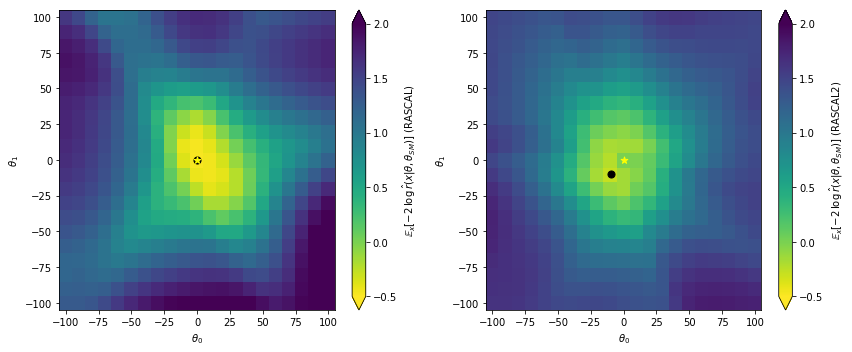

In [9]:
cmin, cmax = -.5, 2.

bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(12,5))



ax = plt.subplot(1,2,1)

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=50., color='black', marker='o')
plt.scatter(0., 0., s=50., color='yellow', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$ (RASCAL)')



ax = plt.subplot(1,2,2)

expected_llr = np.mean(log_r_hat2,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=50., color='black', marker='o')
plt.scatter(0., 0., s=50., color='yellow', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$ (RASCAL2)')



plt.tight_layout()
plt.show()


### 7b. Score estimation, Fisher information, and local model

A second class of methods aims to estimate the score (the gradient of the log likelihood wrt the model parameters) at some reference parameter point such as the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

In [14]:
forge.train(
    method='sally',
    x_filename='data/samples/x_train0.npy',
    t_xz0_filename='data/samples/t_xz_train0.npy',
    n_epochs=10,
    batch_size=256,
    validation_split=None
)

forge.save('models/sally')

11:58  Starting training
11:58    Method:                 sally
11:58    Training data: x at data/samples/x_train0.npy
11:58                   t_xz (theta0) at  data/samples/t_xz_train0.npy
11:58    Method:                 sally
11:58    Hidden layers:          (100, 100, 100)
11:58    Activation function:    tanh
11:58    alpha:                  1.0
11:58    Batch size:             256
11:58    Epochs:                 10
11:58    Learning rate:          0.001 initially, decaying to 0.0001
11:58    Early stopping:         True
11:58  Loading training data
11:58  Found 100000 samples with 2 parameters and 2 observables
11:58  Creating model for method sally
11:58  Training model
11:58    Epoch 1: train loss 0.00 ([0.00214593])
11:58    Epoch 2: train loss 0.00 ([0.00161312])
11:58    Epoch 3: train loss 0.00 ([0.0015727])
11:58    Epoch 4: train loss 0.00 ([0.00155686])
11:58    Epoch 5: train loss 0.00 ([0.00154615])
11:58    Epoch 6: train loss 0.00 ([0.00152293])
11:58    Epoch 7: tr

In [15]:
forge.load('models/sally')

t_hat = forge.evaluate(
    x_filename='data/samples/x_test.npy'
)

fisher_information = forge.calculate_fisher_information(
    'data/samples/x_test.npy',
    n_events=100
)

11:58  Loading settings from models/sally_settings.json
11:58    Found method sally, 2 observables, 2 parameters, (100, 100, 100) hidden layers, tanh activation function
11:58  Loading state dictionary from models/sally_state_dict.pt
11:58  Loading evaluation data
11:58  Starting score evaluation
11:58  Loading evaluation data
11:58  Starting score evaluation
11:58  Expected score (should be close to zero): [-0.00377806  0.00012816]


Let's have a look at the estimated score and how it is related to the observables:

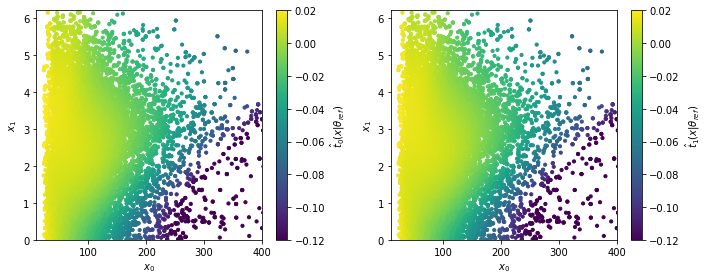

In [28]:
x = np.load('data/samples/x_test.npy')

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[:,0], x[:,1], c=t_hat[:,0], s=10., cmap='viridis', vmin=-0.12, vmax=0.02)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
    plt.xlim(10.,400.)
    plt.ylim(0.,6.2)
    
plt.tight_layout()
plt.show()


Finally, let's look at the Fisher information. For a discussion about what that means and why you should care, see the original publication ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261) or a more detailed, pedagogical introduction in Chapter 4 of ["New Ideas for Effective Higgs Measurements"](https://inspirehep.net/record/1624219).

In [22]:
print('Kinematic Fisher information after 100 events:\n{}'.format(fisher_information))

Kinematic Fisher information after 100 events:
[[ 0.11364707 -0.00392788]
 [-0.00392788  0.0004949 ]]
